In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
import pandas as pd
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
plt.style.use('ggplot')
%matplotlib inline

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./data/mnist', validation_size=0, one_hot=True)
test_len = mnist.test.images.shape[0]
validation_len = int(test_len * 0.1)
num_label=10
train_x = mnist.train.images
test_x = mnist.test.images[validation_len : test_len, :]
validation_x = mnist.test.images[ : validation_len, :]

train_y = mnist.train.labels
test_y = mnist.test.labels[validation_len : test_len]
validation_y = mnist.test.labels[ : validation_len]

print("\nTraining X shape: " + str(train_x.shape))
print("Testing X shape: " + str(test_x.shape))
print("Validation X shape: " + str(validation_x.shape))

print("\nTraining Y shape: " + str(train_y.shape))
print("Testing Y shape: " + str(test_y.shape))
print("Validation Y shape: " + str(validation_y.shape))

Extracting ./data/mnist/train-images-idx3-ubyte.gz
Extracting ./data/mnist/train-labels-idx1-ubyte.gz
Extracting ./data/mnist/t10k-images-idx3-ubyte.gz
Extracting ./data/mnist/t10k-labels-idx1-ubyte.gz

Training X shape: (60000, 784)
Testing X shape: (9000, 784)
Validation X shape: (1000, 784)

Training Y shape: (60000, 10)
Testing Y shape: (9000, 10)
Validation Y shape: (1000, 10)


In [6]:
import scipy.io as sio
import scipy.misc as scimisc
safe_list = [0,2,5,6,8,12,13,14,15,16,17,18,19,21,26]  # other alphabets have characters which look like digits
m = sio.loadmat("./data/data_background.mat")

squished_set = []
for safe_number in safe_list:
    for alphabet in m['images'][safe_number]:
        for letters in alphabet:
            for letter in letters:
                for example in letter:
                    squished_set.append(scimisc.imresize(1 - example[0], (28,28)).reshape(1, 28*28))

safe_images = np.concatenate(squished_set, axis=0)

/Users/senqicao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if sys.path[0] == '':


In [ ]:
M = 10
n_intergal_sample = 50
D=7*7*64
h1=512
D2=10

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

tf.reset_default_graph()
# variables
X = tf.placeholder(tf.float32, shape = [None, 28, 28, 1])
Y = tf.placeholder(tf.float32, [None,10])

w_conv1 = tf.get_variable('w_conv1', [5,5, 1,32], initializer = tf.contrib.layers.xavier_initializer())
w_conv2 = tf.get_variable('w_conv2', [5,5,32,64], initializer = tf.contrib.layers.xavier_initializer())

w_fc1 = tf.get_variable('w_fc1', [7*7*64, h1], initializer = tf.contrib.layers.xavier_initializer())
b_fc1 = tf.get_variable('b_fc1', [1,h1], initializer = tf.contrib.layers.xavier_initializer())
w_fc2 = tf.get_variable('w_fc2', [512, 10], initializer = tf.contrib.layers.xavier_initializer())
b_fc2 = tf.get_variable('b_fc2', [1,10], initializer = tf.contrib.layers.xavier_initializer())

w_fc1_r = tf.get_variable('w_fc1_sigma', [7*7*64, h1], initializer = tf.contrib.layers.xavier_initializer())
b_fc1_r = tf.get_variable('b_fc1_sigma', [1,h1], initializer = tf.contrib.layers.xavier_initializer())
w_fc2_r = tf.get_variable('w_fc2_sigma', [512, 10], initializer = tf.contrib.layers.xavier_initializer())
b_fc2_r = tf.get_variable('b_fc2_sigma', [1,10], initializer = tf.contrib.layers.xavier_initializer())

w_fc1_sigma = w_fc1_r**2
b_fc1_sigma = b_fc1_r**2
w_fc2_sigma = w_fc2_r**2
b_fc2_sigma = b_fc2_r**2

eps1 = tf.random_normal(shape=[n_intergal_sample,D,h1], mean=0.0, stddev=1,dtype=tf.float32)
eps2 = tf.random_normal(shape=[n_intergal_sample,1,h1], mean=0.0, stddev=1,dtype=tf.float32)
eps3 = tf.random_normal(shape=[n_intergal_sample,h1,D2], mean=0.0, stddev=1,dtype=tf.float32)
eps4 = tf.random_normal(shape=[n_intergal_sample,1,D2], mean=0.0, stddev=1,dtype=tf.float32)

w0 = w_fc1 + eps1 * w_fc1_sigma
b0 = b_fc1 + eps2 * b_fc1_sigma
w1 = w_fc2 + eps3 * w_fc2_sigma
b1 = b_fc2 + eps4 * b_fc2_sigma
'''
eps11 = tf.reshape(eps1,[n_intergal_sample,D*h1])
eps22 = tf.reshape(eps2,[n_intergal_sample,1*h1])
eps33 = tf.reshape(eps3,[n_intergal_sample,h1*D2])
eps44 = tf.reshape(eps4,[n_intergal_sample,1*D2])

input_latent = tf.concat([eps11,eps22,eps33,eps44],1)
hidden1 = tf.layers.dense(input_latent, 15, activation=tf.nn.relu)
#hidden2 = tf.layers.dense(hidden1, 5, activation=tf.nn.relu)
#hidden3 = tf.layers.dense(hidden2, 30, activation=tf.nn.relu)
output_latent = tf.layers.dense(hidden1,(D*h1 + 1*h1+ h1*D2 + 1*D2), activation=None)

w0 = tf.reshape(output_latent[:,0:D*h1],[n_intergal_sample,D,h1])
b0 = tf.reshape(output_latent[:,D*h1:D*h1+1*h1],[n_intergal_sample,1,h1])
w1 = tf.reshape(output_latent[:,D*h1+1*h1:D*h1+1*h1+h1*D2],[n_intergal_sample,h1,D2])
b1 = tf.reshape(output_latent[:,D*h1+1*h1+h1*D2:D*h1+1*h1+h1*D2+1*D2],[n_intergal_sample,1,D2])
'''
# network
b=True
con1 = tf.nn.conv2d(X, w_conv1, strides=[1, 1, 1, 1], padding='SAME')
h_conv1 = tf.nn.relu(tf.layers.batch_normalization(con1, training=b))
h_pool1 = max_pool_2x2(h_conv1)

con2 = tf.nn.conv2d(h_pool1, w_conv2, strides=[1, 1, 1, 1], padding='SAME')
h_conv2 = tf.nn.relu(tf.layers.batch_normalization(con2, training=b))
h_pool2 = max_pool_2x2(h_conv2)

h_pool2_flat = tf.layers.flatten(h_pool2)
h_pool2_flat1 = tf.stack([h_pool2_flat]*n_intergal_sample)

h = tf.nn.relu(tf.matmul(h_pool2_flat1, w0) + b0)
logits = tf.matmul(h, w1) + b1
output0 = tf.nn.softmax(logits)#num_sample*batch*10

#evaluation
probs = tf.reduce_sum(output0*Y,2)
prob=tf.reduce_mean(probs,0)#积分
log_prob = tf.log(prob)#取log
p = tf.reduce_mean(log_prob)#求和

output, var0 = tf.nn.moments(output0,0)#batch*10
prob1 = tf.reduce_sum(output*Y,1)

max_p = tf.reduce_max(output,1)
ent = tf.reduce_sum(-tf.log(output+1e-11)*output,1)
Eent = tf.reduce_mean(tf.reduce_sum(-tf.log(output0+1e-11)*output0,2),0)
MI = ent - Eent
var = tf.reduce_sum(var0,1)

correct_pred = tf.equal(tf.argmax(output,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# training
a = 0.00001
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_step = tf.train.AdamOptimizer(a).minimize(-p)
saver = tf.train.Saver()

with tf.Session() as sess:
    start_time = time.time()
    #sess.run(tf.global_variables_initializer())
    model_id=2
    save_path = saver.restore(sess, "./baseline0/classification_mnist1/model.ckpt")
    for i in range(60000*100):
        batch = mnist.train.next_batch(M)
        x_batch = np.reshape(batch[0],[M, 28, 28, 1])
        y_batch = batch[1]
        
        if i%100==0:
            b=False
            #accu = sess.run(accuracy,{X: np.reshape(mnist.train.images,[55000,28,28,1]), Y: mnist.train.labels})
            test_error = sess.run(accuracy, {X:np.reshape(mnist.test.images,[10000,28,28,1]), Y:mnist.test.labels})
            validation_error = sess.run(accuracy, {X:np.reshape(validation_x,[1000,28,28,1]), Y:validation_y})
            maxp_OOD = sess.run(max_p,{X:np.reshape(safe_images,[9200,28,28,1])})
            maxp_in = sess.run(max_p, {X:np.reshape(mnist.test.images,[10000,28,28,1]), Y:mnist.test.labels})
            ent_OOD = sess.run(ent,{X:np.reshape(safe_images,[9200,28,28,1]), Y:mnist.test.labels[:9200]})
            ent_in = sess.run(ent, {X:np.reshape(mnist.test.images,[10000,28,28,1]), Y:mnist.test.labels})
            MI_OOD = sess.run(MI,{X:np.reshape(safe_images,[9200,28,28,1])})
            MI_in = sess.run(MI, {X:np.reshape(mnist.test.images,[10000,28,28,1]), Y:mnist.test.labels})
            var_OOD = sess.run(var,{X:np.reshape(safe_images,[9200,28,28,1])})
            var_in = sess.run(var, {X:np.reshape(mnist.test.images,[10000,28,28,1]), Y:mnist.test.labels})
            
            print ("time:",i, time.time() - start_time, "test accuracy", test_error, "validation_error",validation_error)
            
            print("maxp_OOD:",np.mean(maxp_OOD>0.99),np.mean(maxp_OOD),np.std(maxp_OOD))
            print("maxp_inD:",np.mean(maxp_in>0.99),np.mean(maxp_in),np.std(maxp_in))
            print("ent_OOD:",np.mean(ent_OOD),np.std(ent_OOD), "ent_in:", np.mean(ent_in),np.std(ent_in))
            print("MI_OOD:",np.mean(MI_OOD),np.std(MI_OOD), "MI_in:", np.mean(MI_in),np.std(MI_in))
            print("var_OOD:",np.mean(var_OOD),np.std(var_OOD), "var_in:", np.mean(var_in),np.std(var_in))

            
            safe, risky = np.reshape(maxp_in,[10000,1]), np.reshape(maxp_OOD,[9200,1])
            labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
            labels[:safe.shape[0]] += 1
            examples = np.squeeze(np.vstack((safe, risky)))
            print('AUPR_p:', round(100*average_precision_score(labels, examples), 2))
            print('AUROC_p:', round(100*roc_auc_score(labels, examples), 2))

            risky,safe = np.reshape(ent_in,[10000,1]), np.reshape(ent_OOD,[9200,1])
            labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
            labels[:safe.shape[0]] += 1
            examples = np.squeeze(np.vstack((safe, risky)))
            print('AUPR_entropy:', round(100*average_precision_score(labels, examples), 2))
            print('AUROC_entropy:', round(100*roc_auc_score(labels, examples), 2))
            
            risky,safe = np.reshape(MI_in,[10000,1]), np.reshape(MI_OOD,[9200,1])
            labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
            labels[:safe.shape[0]] += 1
            examples = np.squeeze(np.vstack((safe, risky)))
            print('AUPR_MI:', round(100*average_precision_score(labels, examples), 2))
            print('AUROC_MI:', round(100*roc_auc_score(labels, examples), 2))
            
            risky,safe = np.reshape(var_in,[10000,1]), np.reshape(var_OOD,[9200,1])
            labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
            labels[:safe.shape[0]] += 1
            examples = np.squeeze(np.vstack((safe, risky)))
            print('AUPR_var:', round(100*average_precision_score(labels, examples), 2))
            print('AUROC_var:', round(100*roc_auc_score(labels, examples), 2))
            print("############################################")
            
        if i < 1000:
            a = 0.0001
            b = True
            sess.run(train_step,{X: x_batch, Y: y_batch})
        elif i < 5000:
            a = 0.00005
            b = True
            sess.run(train_step,{X: x_batch, Y: y_batch})
        elif i < 10000:
            a = 0.00001
            b = True
            sess.run(train_step,{X: x_batch, Y: y_batch})
        else:
            a = 0.000005
            b = True
            sess.run(train_step,{X: x_batch, Y: y_batch})
        
        if i%500==0:
            save_path = saver.save(sess, "./baseline0/classification_mnist%s/model.ckpt" % model_id)
            model_id+=1

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./baseline0/classification_mnist1/model.ckpt
time: 0 237.0634150505066 test accuracy 0.9014 validation_error 0.883
maxp_OOD: 0.00010869565217391305 0.44093376 0.16592433
maxp_inD: 0.0109 0.7377145 0.20586404
ent_OOD: 1.5911025 0.36696154 ent_in: 0.86131126 0.5122767
MI_OOD: 0.0367562 0.36696154 MI_in: 0.017501961 0.01301196
var_OOD: 0.015054433 0.008917329 var_in: 0.006695529 0.007009831
AUPR_p: 87.9
AUROC_p: 85.46
AUPR_entropy: 83.9
AUROC_entropy: 86.53
AUPR_MI: 82.8
AUROC_MI: 84.62
AUPR_var: 74.27
AUROC_var: 79.11
############################################
time: 100 590.191822052002 test accuracy 0.9146 validation_error 0.892
maxp_OOD: 0.0002173913043478261 0.47910646 0.18282124
maxp_inD: 0.0331 0.7714536 0.20075643
ent_OOD: 1.5026451 0.40401426 ent_in: 0.7601661 0.508528
MI_OOD: 0.031280115 0.40401426 MI_in: 0.017072706 0.015113546
var_OOD: 0.010261343 0

time: 1500 5456.9106092453 test accuracy 0.9513 validation_error 0.95
maxp_OOD: 0.008478260869565218 0.5951659 0.21316838
maxp_inD: 0.3011 0.90663505 0.14428046
ent_OOD: 1.1608949 0.49667278 ent_in: 0.31980574 0.38328856
MI_OOD: 0.02784028 0.49667278 MI_in: 0.006721103 0.009515311
var_OOD: 0.011593506 0.008126396 var_in: 0.0026840519 0.0054611727
AUPR_p: 90.65
AUROC_p: 89.25
AUPR_entropy: 88.42
AUROC_entropy: 90.21
AUPR_MI: 87.51
AUROC_MI: 89.87
AUPR_var: 81.18
AUROC_var: 86.95
############################################
time: 1600 5793.45631814003 test accuracy 0.9547 validation_error 0.949
maxp_OOD: 0.007173913043478261 0.585843 0.20997879
maxp_inD: 0.3471 0.9117436 0.1430694
ent_OOD: 1.1826196 0.49130684 ent_in: 0.30036703 0.37388515
MI_OOD: 0.024848692 0.49130684 MI_in: 0.00550179 0.008036142
var_OOD: 0.0113574015 0.0075282794 var_in: 0.0020972893 0.0044553443
AUPR_p: 91.98
AUROC_p: 90.48
AUPR_entropy: 89.82
AUROC_entropy: 91.42
AUPR_MI: 89.28
AUROC_MI: 91.3
AUPR_var: 85.64
AUROC_

time: 3000 10649.932582139969 test accuracy 0.9675 validation_error 0.968
maxp_OOD: 0.015 0.61913747 0.2153273
maxp_inD: 0.5 0.9410325 0.11743586
ent_OOD: 1.082045 0.5030709 ent_in: 0.20477432 0.31359547
MI_OOD: 0.023671731 0.5030709 MI_in: 0.0040716617 0.0071620494
var_OOD: 0.010744258 0.008024875 var_in: 0.0017059448 0.004698574
AUPR_p: 93.27
AUROC_p: 92.12
AUPR_entropy: 91.5
AUROC_entropy: 92.84
AUPR_MI: 90.52
AUROC_MI: 92.49
AUPR_var: 85.2
AUROC_var: 90.45
############################################
time: 3100 11001.539072990417 test accuracy 0.9638 validation_error 0.963
maxp_OOD: 0.028695652173913042 0.649968 0.21913546
maxp_inD: 0.4845 0.936442 0.12362376
ent_OOD: 0.9940141 0.52344936 ent_in: 0.21689014 0.3253182
MI_OOD: 0.0234823 0.52344936 MI_in: 0.0048433375 0.008620598
var_OOD: 0.010148134 0.007434325 var_in: 0.0017378355 0.004406441
AUPR_p: 90.58
AUROC_p: 89.44
AUPR_entropy: 88.47
AUROC_entropy: 89.98
AUPR_MI: 86.1
AUROC_MI: 89.0
AUPR_var: 83.64
AUROC_var: 88.35
##########

time: 4600 16219.702084064484 test accuracy 0.9718 validation_error 0.971
maxp_OOD: 0.035652173913043476 0.6679826 0.21757744
maxp_inD: 0.5953 0.953069 0.10681354
ent_OOD: 0.9432253 0.5092548 ent_in: 0.15999375 0.27937332
MI_OOD: 0.021082051 0.5092548 MI_in: 0.003210403 0.0065074936
var_OOD: 0.008750207 0.0066113807 var_in: 0.0012856064 0.0039480375
AUPR_p: 92.34
AUROC_p: 91.25
AUPR_entropy: 90.67
AUROC_entropy: 92.08
AUPR_MI: 89.96
AUROC_MI: 91.73
AUPR_var: 84.24
AUROC_var: 89.87
############################################
time: 4700 16564.984006166458 test accuracy 0.9744 validation_error 0.97
maxp_OOD: 0.029130434782608697 0.65082425 0.21682973
maxp_inD: 0.6113 0.95644706 0.102025315
ent_OOD: 0.9822438 0.507993 ent_in: 0.15340996 0.27008697
MI_OOD: 0.023516893 0.507993 MI_in: 0.0034823956 0.007375185
var_OOD: 0.009844169 0.0076520713 var_in: 0.0011691868 0.0037139712
AUPR_p: 93.57
AUROC_p: 92.64
AUPR_entropy: 92.0
AUROC_entropy: 93.09
AUPR_MI: 89.74
AUROC_MI: 92.0
AUPR_var: 87.98
A

time: 6200 21789.875766038895 test accuracy 0.9786 validation_error 0.973
maxp_OOD: 0.035760869565217394 0.6662257 0.2175912
maxp_inD: 0.6733 0.9633579 0.09523381
ent_OOD: 0.94509554 0.51346594 ent_in: 0.12583755 0.24741079
MI_OOD: 0.021022387 0.51346594 MI_in: 0.0027516952 0.006472965
var_OOD: 0.011580657 0.009434277 var_in: 0.0010636315 0.0037698124
AUPR_p: 94.1
AUROC_p: 93.1
AUPR_entropy: 92.64
AUROC_entropy: 93.73
AUPR_MI: 89.94
AUROC_MI: 92.92
AUPR_var: 90.23
AUROC_var: 92.84
############################################
time: 6300 22133.907522201538 test accuracy 0.9779 validation_error 0.974
maxp_OOD: 0.04739130434782609 0.6703 0.22157413
maxp_inD: 0.6752 0.9636697 0.09532724
ent_OOD: 0.9237179 0.5271117 ent_in: 0.12562436 0.24652229
MI_OOD: 0.022499144 0.5271117 MI_in: 0.0026973733 0.006240161
var_OOD: 0.0099162245 0.0083534885 var_in: 0.0010927859 0.003911845
AUPR_p: 93.29
AUROC_p: 92.48
AUPR_entropy: 91.95
AUROC_entropy: 92.85
AUPR_MI: 91.39
AUROC_MI: 92.81
AUPR_var: 87.68
AUR

time: 7800 27055.61492204666 test accuracy 0.9802 validation_error 0.979
maxp_OOD: 0.03641304347826087 0.664129 0.21547043
maxp_inD: 0.7217 0.96864647 0.08951982
ent_OOD: 0.9447633 0.5013313 ent_in: 0.107531995 0.23039067
MI_OOD: 0.021473344 0.5013313 MI_in: 0.0024132116 0.005964434
var_OOD: 0.010668044 0.0085932445 var_in: 0.0009295791 0.0036734825
AUPR_p: 94.98
AUROC_p: 94.13
AUPR_entropy: 93.73
AUROC_entropy: 94.7
AUPR_MI: 91.99
AUROC_MI: 93.8
AUPR_var: 90.36
AUROC_var: 93.66
############################################


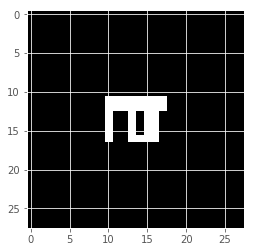

In [39]:
plt.imshow(safe_images[3300].reshape(28,28),cmap='gray')
plt.show()

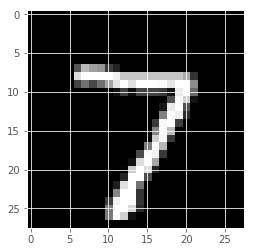

In [40]:
plt.imshow(mnist.test.images[0].reshape(28,28),cmap='gray')
plt.show()

In [37]:
safe_images[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,

In [38]:
mnist.test.images[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     